In [ ]:
!pip install transformers
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    TFAutoModel,
    TFAutoModelWithLMHead
)
from google.colab import drive
from google.colab import files
import json

drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
QUESTION_ID = 'id'
QUESTION_TEXT = 'question'
DIFFICULTY_KEY = 'difficulty'
AVG_PREDICTION = 'prediction'

def create_df(filename):
  df = pd.read_csv(filename)
  df['prediction'] = df['prediction'].fillna(0)
  return df

df = pd.read_csv('/content/gdrive/MyDrive/Thesis/data/neurIPS_edu_competition_text.csv')

In [ ]:
def create_model(model_name, max_length=128, dropout_intern=0.5, dropout_final=0.5):
    """
    It creates the model composed by transformer, specified by model name, + top layers to do regression.
    @param dropout_final: the dropout of the fully connected layer on the top of the transformer
    @param dropout_intern the dropout for fully connected layers in the transformer
    @param max_length: max sequence length
    @param model_name: the name of the huggingface model
    @return: tf.keras model
    """
    # import pre trained model to fine tune
    transformer_model = TFAutoModel.from_pretrained(model_name)
    # specify INTERNAL dropout of the pre trained model
    transformer_model.config.dropout = dropout_intern
    # input of the model
    input_ids = tf.keras.layers.Input(shape=(max_length,), name='input_1', dtype='int32')
    # take the last hidden layer of shape (batch_size, sequence_length, hidden_size = 768))
    embedding_layer = transformer_model([input_ids])[0]
    # take the only embeddings of CLS token
    cls_token = embedding_layer[:, 0, :]
    dropout = tf.keras.layers.Dropout(dropout_final)(cls_token)
    # output layer 1 neuron linear activation function (default one) since we are performing regression
    output = tf.keras.layers.Dense(1)(dropout)
    model = tf.keras.Model(inputs=[input_ids], outputs=output)
    # set optimizer
    optimizer = tf.optimizers.Adam(learning_rate=LR)
    # set MAE as loss
    loss = tf.keras.losses.MeanSquaredError()
    # set other metrics
    metric1 = tf.keras.metrics.MeanAbsoluteError()
    metric2 = tf.keras.metrics.RootMeanSquaredError()
    # compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metric1, metric2])
    # return tf.keras.model
    return model

def create_avg_model(model_name, max_length=128, dropout_intern=0.5, dropout_final=0.5):
  NLP_model = create_model(model_name=model_name, max_length=max_length, dropout_intern=dropout_intern, dropout_final=dropout_final)
  avg_input = tf.keras.layers.Input(shape=(1,),name='input_2')
  concat_layer = tf.keras.layers.concatenate([NLP_model.output, avg_input])
  final_output_layer = tf.keras.layers.Dense(1, activation='linear')(concat_layer)
  model = tf.keras.Model(inputs=[NLP_model.input, avg_input], outputs=final_output_layer)

  # set optimizer
  optimizer = tf.optimizers.Adam(learning_rate=LR)
  # set MAE as loss
  loss = tf.keras.losses.MeanSquaredError()
  # set other metrics
  metric1 = tf.keras.metrics.MeanAbsoluteError()
  metric2 = tf.keras.metrics.RootMeanSquaredError()
  # compile the model
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=[metric1, metric2])
  # return tf.keras.model
  return model

def create_embedding_model(model_name, max_length=128, dropout_intern=0.5, dropout_final=0.5, embedding_size=37):
  NLP_model = create_model(model_name=model_name, max_length=max_length, dropout_intern=dropout_intern, dropout_final=dropout_final)
  embedding_input = tf.keras.layers.Input(shape=(embedding_size,),name='input_2')
  embedding_output = tf.keras.layers.Dense(1, activation='linear')(embedding_input)
  concat_layer = tf.keras.layers.concatenate([NLP_model.output, embedding_output])
  final_output_layer = tf.keras.layers.Dense(1, activation='linear', name='dense2_last')(concat_layer)
  model = tf.keras.Model(inputs=[NLP_model.input, embedding_input], outputs=final_output_layer)

  # set optimizer
  optimizer = tf.optimizers.Adam(learning_rate=LR)
  # set MAE as loss
  loss = tf.keras.losses.MeanSquaredError()
  # set other metrics
  metric1 = tf.keras.metrics.MeanAbsoluteError()
  metric2 = tf.keras.metrics.RootMeanSquaredError()
  # compile the model
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=[metric1, metric2])
  # return tf.keras.model
  return model

def encode(
        samples,
        tokenizer,
        max_length=256,
):
    """
    It encodes the textual information of the questions using the tokenizer
    @param samples: list of tuple tuple (textual information, target difficulty)
    @param tokenizer: the tokenizer
    @param max_length: max sequence length
    @return:
            encoded_text: list of encoded text x
            target_difficulty: list of target difficulty y
    """
    encoded_text = []
    target_difficulty = []
    avg_difficulty = []
    for t in samples:
        text, avg_diff, target = t
        input_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,  # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True,  # pads to the right by default
            truncation='longest_first'
        )
        encoded_text.append(input_dict['input_ids'])
        target_difficulty.append(target)
        avg_difficulty.append(avg_diff)
    return encoded_text, avg_difficulty, target_difficulty


def load_mlm_model_weights(model, model_name,
                           path='/tf_model.h5'):
    """
    @param model: tf.keras model to set the weights to
    @param model_name: the name of the huggingface model
    @param path: file path containing the weights in format .h5
    @return: tf.keras model with the new weights
    """
    mlm_model = TFAutoModelWithLMHead.from_pretrained(model_name)
    mlm_model.load_weights(path)
    # set the pre-trained weights to the 'transformer' layer (see model.summary())
    model.layers[1].set_weights(mlm_model.layers[0].get_weights())
    return model


BATCH_SIZE = 64
SEED_SPLIT_DATASET = 1234
EPOCHS = 100
MAX_LENGTH = 128
LR = 1e-5
DROPOUT_FINAL = 0.01
DROPOUT_INTERN = 0.01
MODEL_TO_FT = 'bert-base-uncased'
PATIENCE = 20
LOAD_MLM_WEIGHTS = False  # True to use the weights of MLM fine-tuned model
TPU = False

AUTO = tf.data.experimental.AUTOTUNE

if TPU:
    # Create strategy from tpu
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

# train, validation, test split
train, test = train_test_split(df[QUESTION_ID], test_size=0.2, random_state=SEED_SPLIT_DATASET)
df_train = df[df[QUESTION_ID].isin(train)]
df_test = df[df[QUESTION_ID].isin(test)]
train, validation = train_test_split(df_train[QUESTION_ID], test_size=0.1, random_state=SEED_SPLIT_DATASET)
df_train = df[df[QUESTION_ID].isin(train)]
df_validation = df[df[QUESTION_ID].isin(validation)]

test = list(zip(df_test[QUESTION_TEXT], df_test[AVG_PREDICTION], df_test[DIFFICULTY_KEY]))
train = list(zip(df_train[QUESTION_TEXT], df_train[AVG_PREDICTION], df_train[DIFFICULTY_KEY]))
validation = list(zip(df_validation[QUESTION_TEXT], df_validation[AVG_PREDICTION], df_validation[DIFFICULTY_KEY]))


train_length = len(train)

print('#train', len(train))
print('#test', len(test))
print('#validation', len(validation))

# define the tokenizer specific for the model
tokenizer = AutoTokenizer.from_pretrained(MODEL_TO_FT)

# encode the data
x_train, x_diff_train, y_train = encode(train, tokenizer, max_length=MAX_LENGTH)
x_test, x_diff_test, y_test = encode(test, tokenizer, max_length=MAX_LENGTH)
x_val, x_diff_val, y_val = encode(validation, tokenizer, max_length=MAX_LENGTH)


# transform the dataset into a tf.dataset
train_data = (
    tf.data.Dataset
        .from_tensor_slices(({'input_1': x_train, 'input_2': x_diff_train}, y_train))
        .repeat(-1)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
)
valid_data = (
    tf.data.Dataset
        .from_tensor_slices(({'input_1': x_val, 'input_2': x_diff_val}, y_val))
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
)
test_data = (
    tf.data.Dataset
        .from_tensor_slices(({'input_1': x_test, 'input_2': x_diff_test}, y_test))
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
)

#train 682
#test 190
#validation 76


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', mode='min', patience=PATIENCE,
                                            restore_best_weights=True)
# set train_steps in order to go through all the train ds
train_steps = train_length // BATCH_SIZE

# list of random seeds
seeds = [1,2,3]
# lists to store the results
train_result_T = []
valid_result_T = []
test_result_T = []
test_extremes_result_T = []

# repeat the training len(seeds) times
for SEED_TF in seeds:
    # set various SEED
    np.random.seed(SEED_TF)
    tf.random.set_seed(SEED_TF)
    os.environ['TF_DETERMINISTIC_OPS'] = str(SEED_TF)

    if TPU:
      with strategy.scope():
          model = create_avg_model(model_name=MODEL_TO_FT, dropout_intern=DROPOUT_INTERN, dropout_final=DROPOUT_FINAL,
                             max_length=MAX_LENGTH)
    else:
         model = create_avg_model(model_name=MODEL_TO_FT, dropout_intern=DROPOUT_INTERN, dropout_final=DROPOUT_FINAL,
                         max_length=MAX_LENGTH)

    # to set mlm weights to our model
    if LOAD_MLM_WEIGHTS:
        model = load_mlm_model_weights(model, model_name=MODEL_TO_FT)
    model.summary()

    # fit the model
    history = model.fit(train_data,
                        epochs=EPOCHS,
                        validation_data=valid_data,
                        steps_per_epoch=train_steps,
                        callbacks=[callback]
                        )
    # print results
    metrics = model.metrics_names

    description = 'Train result:\n'
    train_result = model.evaluate(train_data, steps=train_steps, verbose=0);
    description += str(list(zip(metrics, train_result))) + '\n'

    description += 'Validation result:\n'
    valid_result = model.evaluate(valid_data, verbose=0);
    description += str(list(zip(metrics, valid_result))) + '\n'

    description += 'Test result:\n'
    test_result = model.evaluate(test_data, verbose=0);
    description += str(list(zip(metrics, test_result))) + '\n'
    print(description)

    # append results
    train_result_T.append(train_result)
    valid_result_T.append(valid_result)
    test_result_T.append(test_result)

# print average results
print('train     MSE, MAE, RMSE: ',[round((x/len(seeds)),4) for x in [sum(i) for i in zip(*train_result_T)]])
print('valid     MSE, MAE, RMSE: ',[round((x/len(seeds)),4)  for x in [sum(i) for i in zip(*valid_result_T)]])
print('test      MSE, MAE, RMSE: ',[round((x/len(seeds)),4)  for x in [sum(i) for i in zip(*test_result_T)]])

In [ ]:
test_predictions = model.predict(test_data)
valid_predictions = model.predict(valid_data)
train_predictions = model.predict(train_data,steps=train_steps)

df_test.reset_index(inplace=True)
df_validation.reset_index(inplace=True)
df_train.reset_index(inplace=True)

df_test['predicted_difficulty'] = pd.DataFrame(test_predictions.flatten())
df_test['split'] = 'test'
df_validation['predicted_difficulty'] = pd.DataFrame(valid_predictions.flatten())
df_validation['split'] = 'validation'
df_train['predicted_difficulty'] = pd.DataFrame(train_predictions.flatten())
df_train['split'] = 'train'

results = pd.concat([df_test,df_validation,df_train])
results.to_csv('/content/gdrive/MyDrive/Thesis/data/predictions_avg+bert2.csv', index = False)

3/3 [==============================] - 1s 490ms/step


<ipython-input-15-ca997fba00a6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_difficulty'] = pd.DataFrame(test_predictions.flatten())
<ipython-input-15-ca997fba00a6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['split'] = 'test'


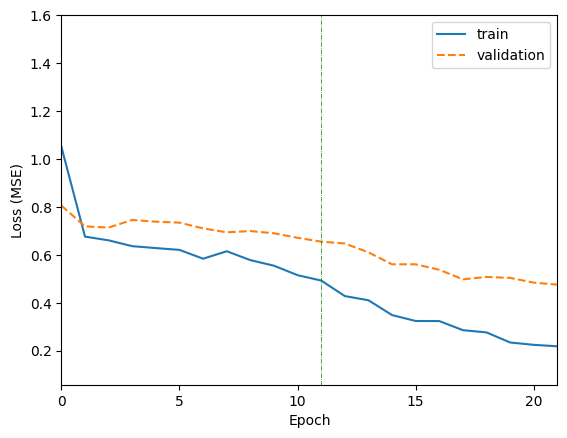

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
fig, ax = plt.subplots()

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.lines[1].set_linestyle("--")

ax.set_ylabel('Loss (MSE)')
ax.set_xlabel('Epoch')
ax.legend(['train', 'validation'])
ax.set_xlim([0, 21])
ax.set_xticks([0,5,10,15,20])
ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2,1.4,1.6])

plt.axvline(x=11,color='green', ls='-.', lw=0.5)
plt.show()
fig.savefig("train_val_ca_line_24.pdf")

10/10 [==============================] - 5s 537ms/step


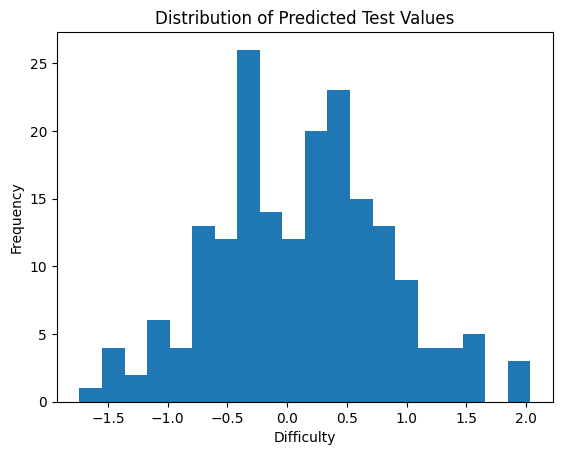

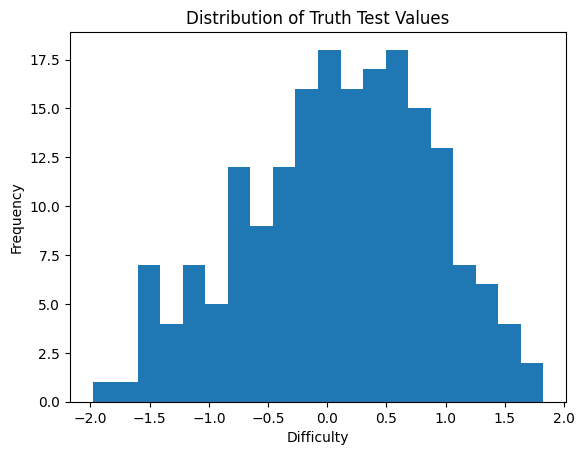

In [ ]:
test_predictions = model.predict(test_data)
valid_predictions = model.predict(valid_data)
train_predictions = model.predict(train_data,steps=train_steps)

# Plotting the distribution of difficulty values
plt.hist(test_predictions, bins=20)  # Adjust the number of bins as per your preference
plt.xlabel('Difficulty')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Test Values')
plt.show()

# Plotting the distribution of difficulty values
plt.hist(y_test, bins=20)  # Adjust the number of bins as per your preference
plt.xlabel('Difficulty')
plt.ylabel('Frequency')
plt.title('Distribution of Truth Test Values')
plt.show()